In [1]:
import numpy as np
import matplotlib.cm as cm
from matplotlib import ticker
import math
import scipy
from scipy import spatial
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import dask
from sklearn.neighbors import KDTree
import netCDF4
from metpy import calc
from metpy.units import units

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d
from IPython.display import HTML
from matplotlib import animation
from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde
import skimage
import plotly.graph_objects as go

from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import ticker
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from statistics import mode
from matplotlib import transforms
import netCDF4

/export/nfs0home/hmangipu/miniconda3/envs/GPU/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
fz = 15*1.5
lw = 4
siz = 100
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YTEXT = 0.3 # Text placement
plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
matplotlib.rcParams['lines.linewidth'] = lw

In [3]:
labels_3_original = np.load("../compressed_data/Scaled_Mandt_Method_Small_SPCAM_To_UM_Interp_Labels_4503_Z_3.npy").astype(int)
labels_3_SAM = np.load("../compressed_data/Scaled_Mandt_Method_Small_SAM_To_UM_Interp_Labels_4503_Z_3.npy").astype(int)
labels_3_UM = np.load("../compressed_data/Small_UM_Labels_4503_Z_3.npy").astype(int)
labels_3_SHIELD = np.load("../compressed_data/Scaled_Mandt_Method_Small_SHIELD_To_UM_Interp_Labels_4503_Z_3.npy").astype(int)
labels_3_ICON = np.load("../compressed_data/Scaled_Mandt_Method_Small_ICON_To_UM_Interp_Labels_4503_Z_3.npy").astype(int)
labels_3_ARPEGE = np.load("../compressed_data/Scaled_Mandt_Method_Small_ARPEGE_To_UM_Interp_Labels_4503_Z_3.npy").astype(int)
labels_3_NICAM = np.load("../compressed_data/Scaled_Mandt_Method_Small_NICAM_To_UM_Interp_Labels_4503_Z_3.npy").astype(int)
labels_3_GEM = np.load("../compressed_data/Scaled_Mandt_Method_Small_GEM_To_UM_Interp_Labels_4503_Z_3.npy").astype(int)
labels_3_IFS = np.load("../compressed_data/Scaled_Mandt_Method_Small_IFS_To_UM_Interp_Labels_4503_Z_3.npy").astype(int)

In [ ]:
ARPEGE = np.load("/DFS-L/DATA/pritchard/gmooers/Finished_DYAMOND/DYAMOND/ARPEGE/Raw_Small_Unscaled_ARPEGE_W_Test.npy", mmap_mode="r")
ARPEGE_P = np.load("/DFS-L/DATA/pritchard/gmooers/Finished_DYAMOND/DYAMOND/ARPEGE/Raw_Small_Unscaled_ARPEGE_P_Test.npy", mmap_mode="r")/100.

SPCAM = np.load("/DFS-L/DATA/pritchard/gmooers/Finished_DYAMOND/DYAMOND/SAM_ORIGIN/Small_Unscaled_MY_SAM_W_Test.npy", mmap_mode="r")
path = "/DFS-L/DATA/pritchard/gmooers/Raw_Data_Storage/MAPS/SPCAM/100_Days/New_SPCAM5/archive/TimestepOutput_Neuralnet_SPCAM_216/atm/hist/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-20-00000.nc"
extra_variables = xr.open_dataset(path)
ha = extra_variables.hyam.values
hb = extra_variables.hybm.values
SPCAM_P = extra_variables.lev.values

IFS = np.load("/DFS-L/DATA/pritchard/gmooers/Finished_DYAMOND/DYAMOND/IFS/Raw_Small_Unscaled_IFS_W_Test.npy", mmap_mode="r")
path_to_file = '/DFS-L/DATA/pritchard/gmooers/DYAMOND/Winter-IFS-4K/wa_*'
extra_variables = xr.open_mfdataset(path_to_file)
hyam_ifs = xr.DataArray.squeeze(extra_variables.hyam)
hybm_ifs = xr.DataArray.squeeze(extra_variables.hybm)
new_pressures = (hyam_ifs+hybm_ifs*1e5)/100.
new_pressures = new_pressures.values
IFS_P = new_pressures[0,:]

NICAM = np.load("/DFS-L/DATA/pritchard/gmooers/Finished_DYAMOND/DYAMOND/NICAM/Raw_No_Nans_But_Land_Small_Unscaled_NICAM_W_Test.npy", mmap_mode="r")
path_to_file = '/DFS-L/DATA/pritchard/gmooers/DYAMOND/Winter-NICAM-3K/wa_*'
extra_variables = xr.open_mfdataset(path_to_file)
heights_nicam = xr.DataArray.squeeze(extra_variables.lev)
NICAM_P = calc.height_to_pressure_std(heights_nicam)._magnitude
NICAM_P[-2] = NICAM_P[-3]/2.0
NICAM_P[-1] = NICAM_P[-3]/4.0
NICAM = NICAM[:125000,:,:]

GEM = np.load("/DFS-L/DATA/pritchard/gmooers/Finished_DYAMOND/DYAMOND/GEM/Raw_Small_Unscaled_GEM_W_Test.npy", mmap_mode="r")
gem_test_P = np.load("/DFS-L/DATA/pritchard/gmooers/Finished_DYAMOND/DYAMOND/GEM/Raw_Small_Unscaled_GEM_P_Test.npy", mmap_mode="r")/100.
dynamics = np.arange(1,117,2)
GEM_P = gem_test_P[:,dynamics,:]

UM = np.load("/DFS-L/DATA/pritchard/gmooers/Finished_DYAMOND/DYAMOND/UM/Raw_Small_Unscaled_UM_W_Test.npy", mmap_mode="r")
UM_P = np.load("/DFS-L/DATA/pritchard/gmooers/Finished_DYAMOND/DYAMOND/UM/Raw_Small_Unscaled_UM_P_Test.npy", mmap_mode="r")/100.

SHIELD = np.load("/DFS-L/DATA/pritchard/gmooers/Finished_DYAMOND/DYAMOND/SHIELD/Raw_Small_Unscaled_SHIELD_W_Test.npy", mmap_mode="r")
SHIELD_P = np.load("/DFS-L/DATA/pritchard/gmooers/Finished_DYAMOND/DYAMOND/SHIELD/height_levels.npy", mmap_mode="r")

SAM = np.load("/DFS-L/DATA/pritchard/gmooers/PD_7_10_22/Preprocessed_Data/DYAMOND/SAM_IMPROVED/Raw_Small_Unscaled_SAM_W_Test.npy", mmap_mode="r")
path_to_file = '/DFS-L/DATA/pritchard/gmooers/DYAMOND/Winter-SAM-4K/wa_*'
extra_variables = xr.open_mfdataset(path_to_file)
z_sam = xr.DataArray.squeeze(extra_variables.z)
SAM_P = calc.height_to_pressure_std(z_sam)._magnitude

ICON = np.load("/DFS-L/DATA/pritchard/gmooers/Finished_DYAMOND/DYAMOND/ICON/Raw_Small_Unscaled_ICON_W_Test.npy", mmap_mode="r")
ICON_P = np.load("/DFS-L/DATA/pritchard/gmooers/Finished_DYAMOND/DYAMOND/ICON/Raw_Small_Unscaled_ICON_P_Test.npy", mmap_mode="r")


Group_3_ww_mean_profile_1_sam = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/mean_ww_profile_sam_interp_to_um_1.npy")
Group_3_ww_mean_profile_2_sam = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/mean_ww_profile_sam_interp_to_um_2.npy")
Group_3_ww_mean_profile_3_sam = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/mean_ww_profile_sam_interp_to_um_3.npy")

Group_3_ww_mean_profile_1_nicam = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/improved_mean_ww_profile_nicam_interp_to_um_1.npy")
Group_3_ww_mean_profile_2_nicam = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/improved_mean_ww_profile_nicam_interp_to_um_2.npy")
Group_3_ww_mean_profile_3_nicam = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/improved_mean_ww_profile_nicam_interp_to_um_3.npy")

Group_3_ww_mean_profile_1_spcam = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/mean_ww_profile_spcam_interp_to_um_1.npy")
Group_3_ww_mean_profile_2_spcam = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/mean_ww_profile_spcam_interp_to_um_2.npy")
Group_3_ww_mean_profile_3_spcam = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/mean_ww_profile_spcam_interp_to_um_3.npy")

Group_3_ww_mean_profile_1_ifs = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/mean_ww_profile_ifs_interp_to_um_1.npy")
Group_3_ww_mean_profile_2_ifs = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/mean_ww_profile_ifs_interp_to_um_2.npy")
Group_3_ww_mean_profile_3_ifs = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/mean_ww_profile_ifs_interp_to_um_3.npy")

Group_3_ww_mean_profile_1_um = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/mean_ww_profile_um_1.npy")
Group_3_ww_mean_profile_2_um = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/mean_ww_profile_um_2.npy")
Group_3_ww_mean_profile_3_um = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/mean_ww_profile_um_3.npy")

Group_3_ww_mean_profile_1_shield = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/mean_ww_profile_shield_interp_to_um_1.npy")
Group_3_ww_mean_profile_2_shield = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/mean_ww_profile_shield_interp_to_um_2.npy")
Group_3_ww_mean_profile_3_shield = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/mean_ww_profile_shield_interp_to_um_3.npy")

Group_3_ww_mean_profile_1_icon = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/mean_ww_profile_icon_interp_to_um_1.npy")
Group_3_ww_mean_profile_2_icon = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/mean_ww_profile_icon_interp_to_um_2.npy")
Group_3_ww_mean_profile_3_icon = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/mean_ww_profile_icon_interp_to_um_3.npy")

Group_3_ww_mean_profile_1_arpege = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/mean_ww_profile_arpege_interp_to_um_1.npy")
Group_3_ww_mean_profile_2_arpege = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/mean_ww_profile_arpege_interp_to_um_2.npy")
Group_3_ww_mean_profile_3_arpege = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/mean_ww_profile_arpege_interp_to_um_3.npy")

Group_3_ww_mean_profile_1_gem = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/mean_ww_profile_gem_interp_to_um_1.npy")
Group_3_ww_mean_profile_2_gem = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/mean_ww_profile_gem_interp_to_um_2.npy")
Group_3_ww_mean_profile_3_gem = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/mean_ww_profile_gem_interp_to_um_3.npy")

In [ ]:
UM_P_Coord = np.mean(np.mean(UM_P, axis=2), axis=0)
ICON_P_Coord = np.mean(np.mean(ICON_P, axis=2),axis=0)/100.
ARPEGE_P_Coord = np.mean(np.mean(ARPEGE_P, axis=2),axis=0)
GEM_P_Coord = np.mean(np.mean(GEM_P, axis=2),axis=0)

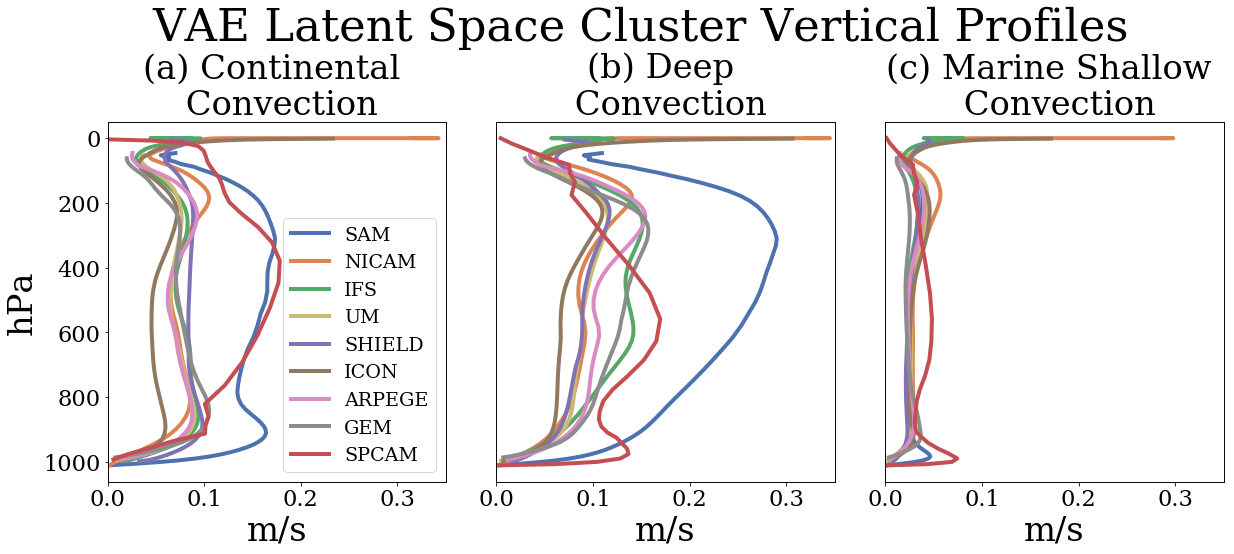

In [77]:
fz = 15*1.5
colors = sns.color_palette("deep", 9)


fig, ax = plt.subplots(1,3,figsize=(20,8))
ax[0].plot(Group_3_ww_mean_profile_1_sam, SAM_P, color=colors[0], label="SAM")
ax[0].plot(Group_3_ww_mean_profile_1_nicam, NICAM_P, color=colors[1], label="NICAM")
ax[0].plot(Group_3_ww_mean_profile_1_ifs, IFS_P, color=colors[2], label="IFS")
ax[0].plot(Group_3_ww_mean_profile_1_um, UM_P_Coord, color=colors[8], label="UM")
ax[0].plot(Group_3_ww_mean_profile_1_shield, SHIELD_P, color=colors[4], label="SHIELD")
ax[0].plot(Group_3_ww_mean_profile_1_icon[:-1], ICON_P_Coord, color=colors[5], label="ICON")
ax[0].plot(Group_3_ww_mean_profile_1_arpege, ARPEGE_P_Coord, color=colors[6], label="ARPEGE")
ax[0].plot(Group_3_ww_mean_profile_1_gem, GEM_P_Coord, color=colors[7], label="GEM")
ax[0].plot(Group_3_ww_mean_profile_1_spcam, SPCAM_P, color=colors[3], label="SPCAM")
ax[0].set_ylim(ax[0].get_ylim()[::-1])
# ax[0].set_xticks([])
ax[0].set_xlim(0,0.35)
ax[0].set_title("(a) Continental \n Convection", fontsize=fz*1.5)
ax[0].legend(loc="lower right", fontsize=fz*.85)
ax[0].tick_params(axis='y', labelsize=fz*1)
ax[0].tick_params(axis='x', labelsize=fz*1)


axes1 = ax[0].twinx()
axes1.set_yticks([])
axes1.set_xlim(0, 0.35)


ax[1].plot(Group_3_ww_mean_profile_2_sam, SAM_P, color=colors[0], label="SAM")
ax[1].plot(Group_3_ww_mean_profile_2_nicam, NICAM_P, color=colors[1], label="NICAM")
ax[1].plot(Group_3_ww_mean_profile_2_ifs, IFS_P, color=colors[2], label="IFS")
ax[1].plot(Group_3_ww_mean_profile_2_um, UM_P_Coord, color=colors[8], label="UM")
ax[1].plot(Group_3_ww_mean_profile_2_shield, SHIELD_P, color=colors[4], label="SHIELD")
ax[1].plot(Group_3_ww_mean_profile_2_icon[:-1], ICON_P_Coord, color=colors[5], label="ICON")
ax[1].plot(Group_3_ww_mean_profile_2_arpege, ARPEGE_P_Coord, color=colors[6], label="ARPEGE")
ax[1].plot(Group_3_ww_mean_profile_2_gem, GEM_P_Coord, color=colors[7], label="GEM")
ax[1].set_ylim(ax[1].get_ylim()[::-1])
ax[1].set_xlim(0,0.35)
ax[1].set_title("(b) Deep \n Convection", fontsize = fz*1.5)
ax[1].set_xlabel("m/s",  fontsize = fz*1.5)
ax[1].set_yticks([])
ax[1].tick_params(axis='x', labelsize=fz*1 )


axes2 = ax[1].twinx()
axes2.plot(Group_3_ww_mean_profile_2_spcam, SPCAM_P, color=colors[3], label="SPCAM")
axes2.set_yticks([])
axes2.set_xlim(0, 0.35)

ax[2].plot(Group_3_ww_mean_profile_3_sam, SAM_P, color=colors[0], label="SAM")
ax[2].plot(Group_3_ww_mean_profile_3_nicam, NICAM_P, color=colors[1], label="NICAM")
ax[2].plot(Group_3_ww_mean_profile_3_ifs, IFS_P, color=colors[2], label="IFS")
ax[2].plot(Group_3_ww_mean_profile_3_um, UM_P_Coord, color=colors[8], label="UM")
ax[2].plot(Group_3_ww_mean_profile_3_shield, SHIELD_P, color=colors[4], label="SHIELD")
ax[2].plot(Group_3_ww_mean_profile_3_icon[:-1], ICON_P_Coord, color=colors[5], label="ICON")
ax[2].plot(Group_3_ww_mean_profile_3_arpege, ARPEGE_P_Coord, color=colors[6], label="ARPEGE")
ax[2].plot(Group_3_ww_mean_profile_3_gem, GEM_P_Coord, color=colors[7], label="GEM")
ax[2].set_ylim(ax[2].get_ylim()[::-1])
ax[2].set_xlim(0,0.35)
ax[2].set_yticks([])
ax[2].set_title("(c) Marine Shallow \n Convection", fontsize = fz*1.5)

axes3 = ax[2].twinx()
axes3.plot(Group_3_ww_mean_profile_3_spcam, SPCAM_P, color=colors[3], label="SPCAM")
axes3.set_yticks([])
axes3.set_xlim(0, 0.35)

ax[2].set_xlabel("m/s",  fontsize = fz*1.5)
ax[1].set_xlabel("m/s",  fontsize = fz*1.5)
ax[0].set_xlabel("m/s",  fontsize = fz*1.5)
ax[0].set_ylabel("hPa",  fontsize = fz*1.5)
ax[0].tick_params(axis='y', labelsize=fz*1 )
ax[0].tick_params(axis='x', labelsize=fz*1 )
ax[1].tick_params(axis='x', labelsize=fz*1 )
ax[2].tick_params(axis='x', labelsize=fz*1 )



# fig.delaxes(ax[1])
plt.suptitle("VAE Latent Space Cluster Vertical Profiles ", fontsize = fz*2, y = 0.95,)

plt.subplots_adjust(wspace=0.15, hspace=0.3)
# fig.subplots_adjust(bottom=0.049)
fig.subplots_adjust(top=0.75)
plt.savefig("../Figures/Figure_S8.png", bbox_inches='tight',pad_inches = 0)
plt.savefig("../Figures/Figure_S8.pdf", bbox_inches='tight',pad_inches = 0)